In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_8DLorenz.recursive_LSTM_PostMeanScore_8DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [19]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


In [25]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLorenz"
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file and "LR4" not in file:
            if "OOSDriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "OOSDriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [26]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config)
len(Nepochs_track)

12

In [27]:
drift_track_rmses = {}
for f_idx in tqdm(range(len(Nepochs_track))):
    Nepoch = Nepochs_track[f_idx]
    true = drift_true_files[f_idx]
    local = drift_local_files[f_idx]
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
drift_track_rmses

100%|██████████| 12/12 [00:01<00:00, 10.07it/s]


{60: 0.24044320098576644,
 100: 0.2177483683192248,
 150: 0.21197113937538994,
 300: 0.20451129444988086,
 960: 0.20937177367949347,
 1440: 0.23219022774744785,
 1920: 0.24630410710077966,
 2920: 0.280599174601031,
 6920: 0.20604239267281566,
 7190: 0.22867042818078387,
 8190: 0.2363236739352387,
 12920: 0.2833045411874099}

In [28]:
toSave = False
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])

In [29]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = common_epochs
start_idx = 2
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

In [ ]:
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="RMSE Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
#track_rmses /= track_rmses[0]
sc2 = ax2.scatter(common_epochs, track_rmses, s=10, color="red",label="Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for 8D-Lorenz with $F = 0.75$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, loc="upper center", fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f8DLnz_Losses_PM_LSTM_{round(config.forcing_const,3)}FConst").replace(".", "")+".png")
plt.show()
plt.close()
losses[-1]/losses[start_idx]

In [ ]:
raise RuntimeError

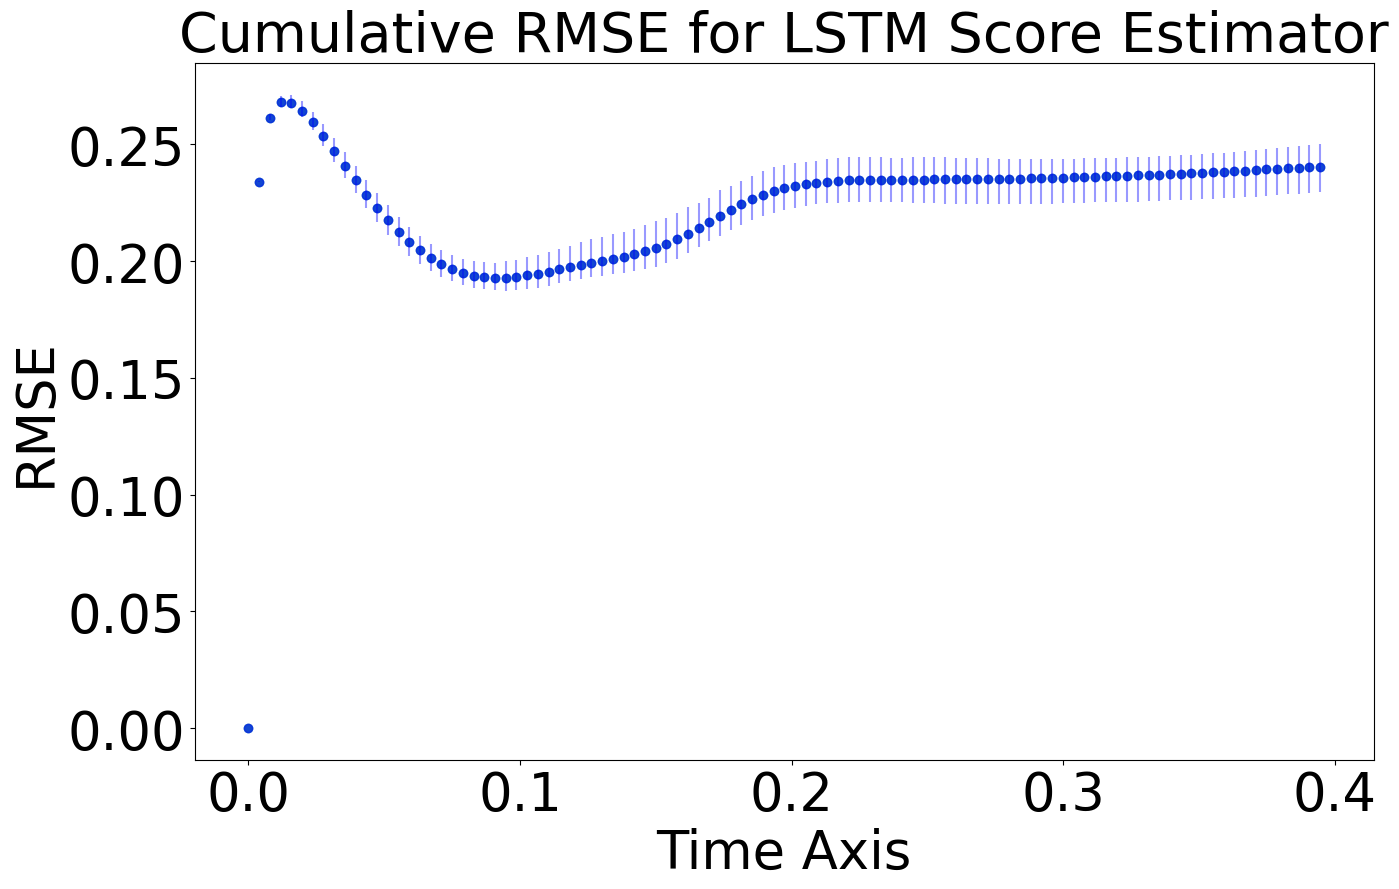

Final time cumulative RMSE local-time error 0.24044320098576644 with final IQR (0.22951611764107704, 0.2500164615901418) at Nepoch 150 for 0.75FConst



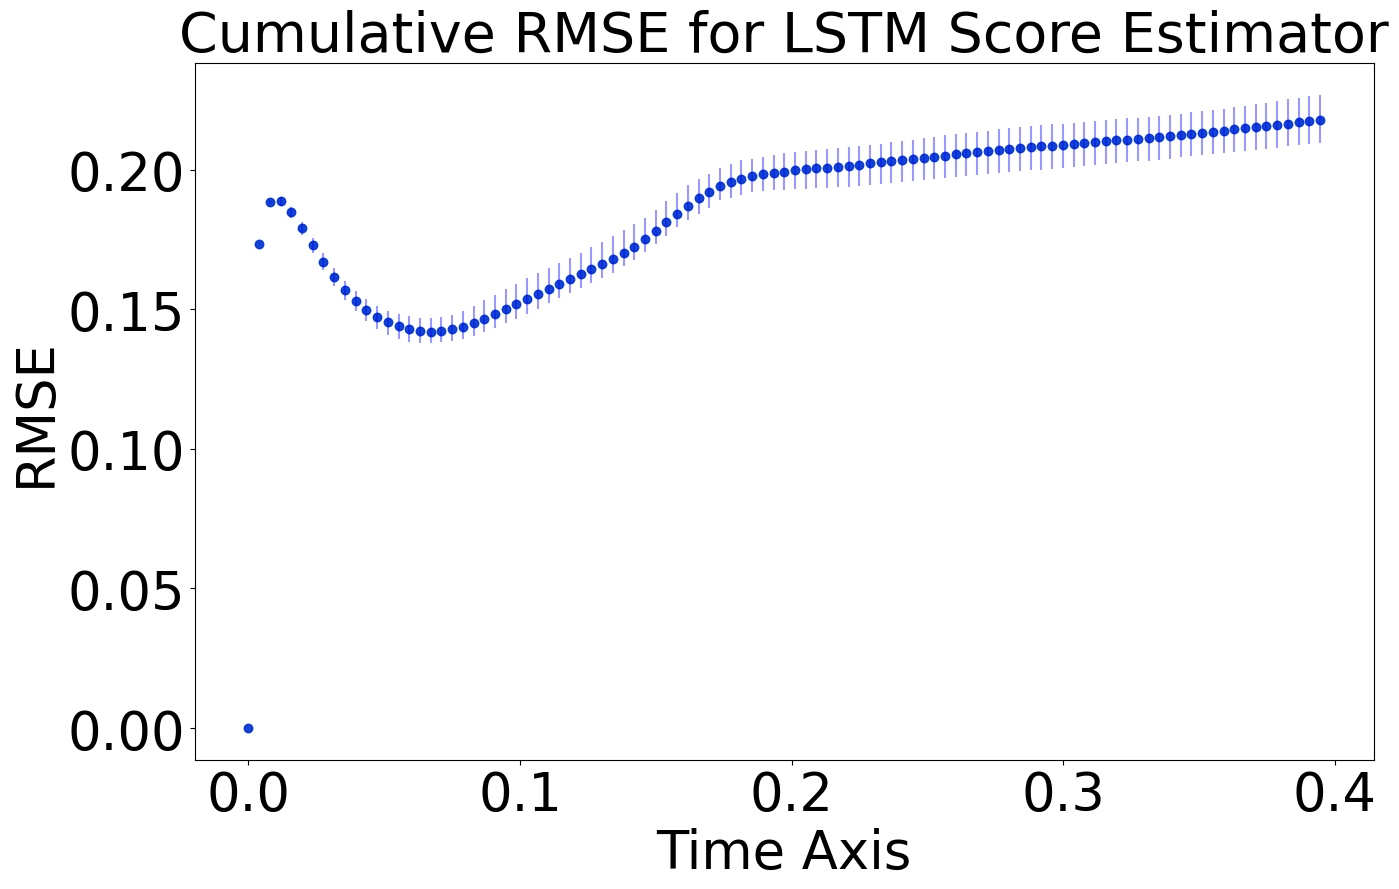

Final time cumulative RMSE local-time error 0.2177483683192248 with final IQR (0.20947906668082064, 0.2268052456934189) at Nepoch 300 for 0.75FConst



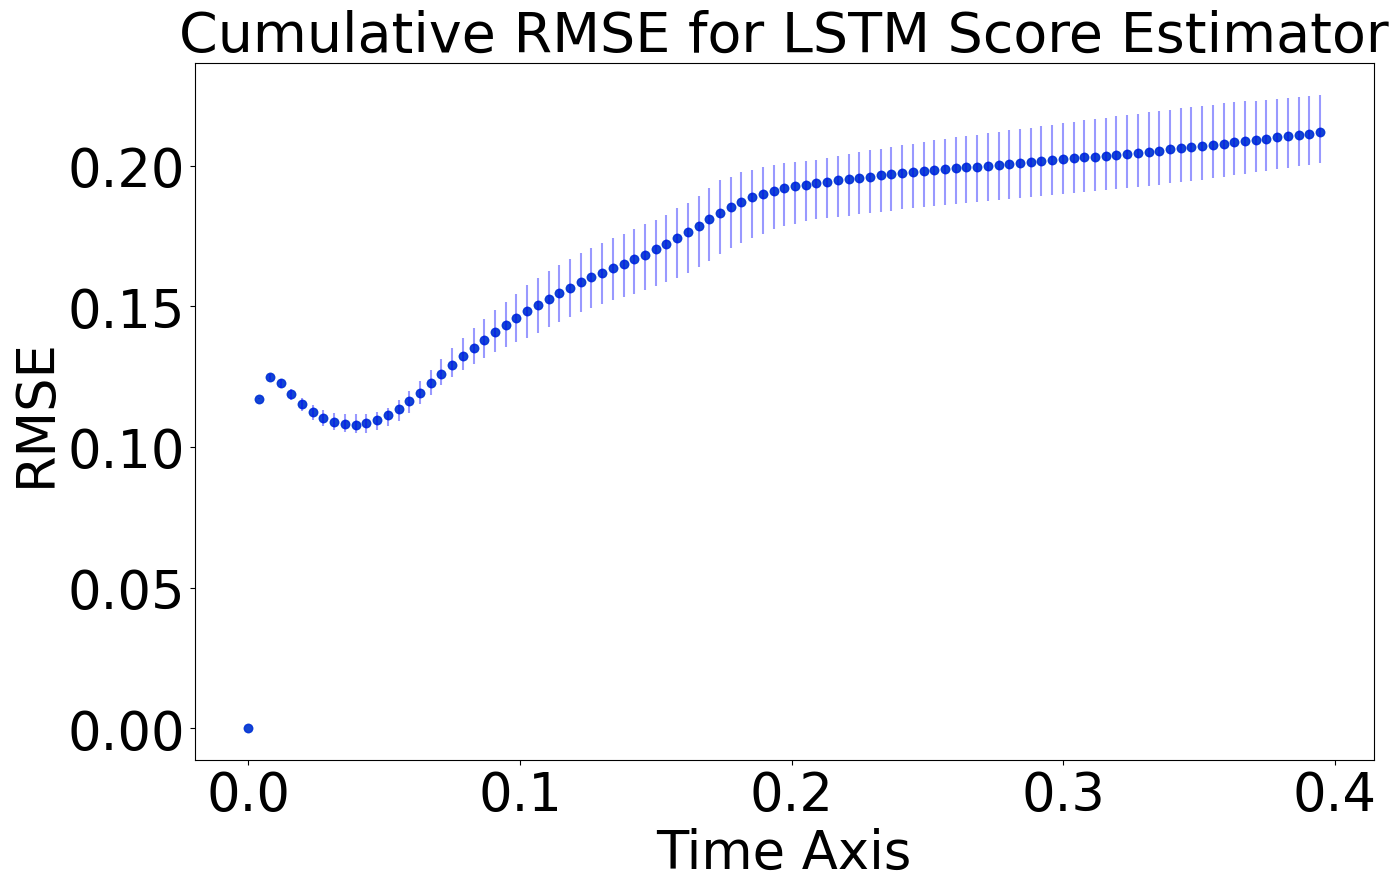

Final time cumulative RMSE local-time error 0.21197113937538994 with final IQR (0.20097822979827565, 0.2253597454973702) at Nepoch 960 for 0.75FConst



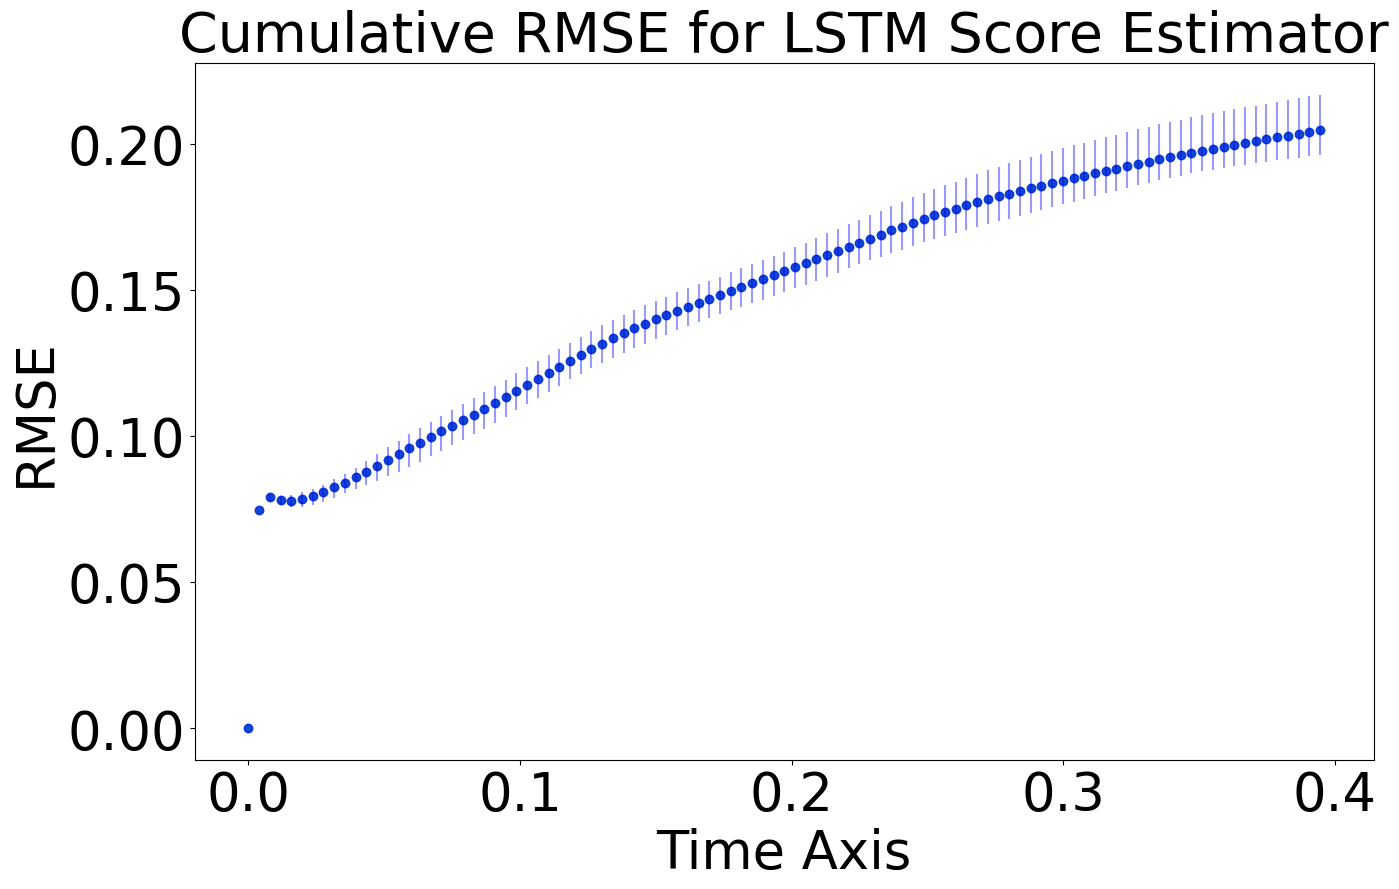

Final time cumulative RMSE local-time error 0.20451129444988086 with final IQR (0.1962377709055127, 0.2167246211036659) at Nepoch 1440 for 0.75FConst



In [30]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    true = drift_true_files[f_idx]
    local = drift_local_files[f_idx]
    try:
        num_diff_times = 1
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f8DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue